# Прикладная статистика и анализ данных
## Задание 2.5


**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.
* В каждой задаче не забывайте делать **пояснения и выводы**.
* За задание можно получить **8 баллов**.

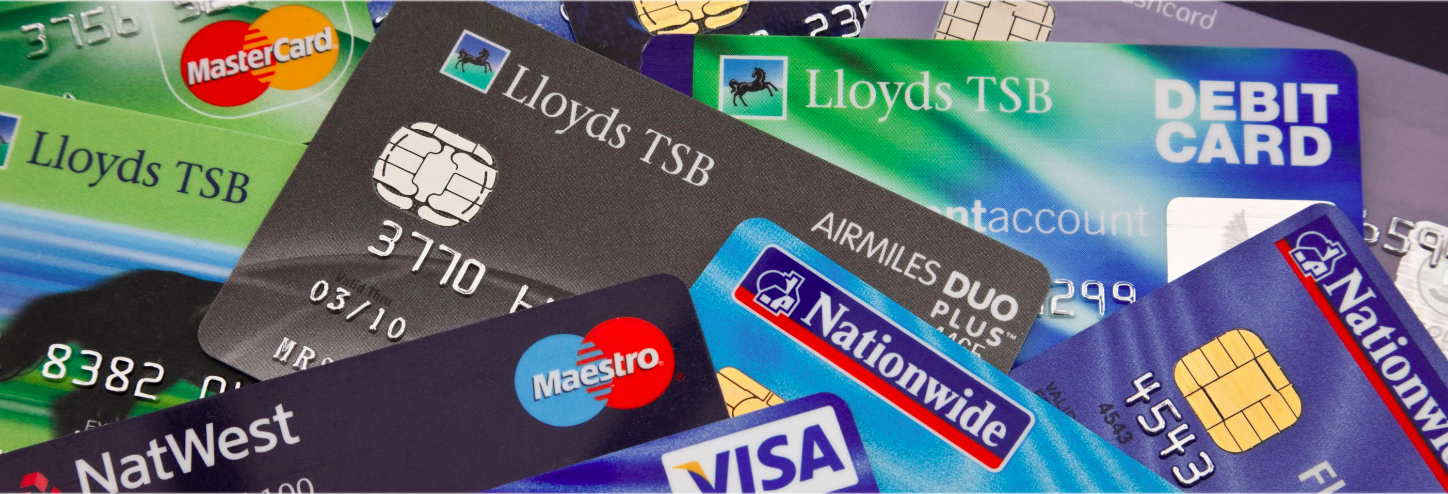

Одна из важных задач банковских организаций — распознавание мошеннических операции с кредитными картами, например, чтобы клиенты не платили за те операции, которые они не совершают.  

**Данные**

Скачайте данные https://www.kaggle.com/mlg-ulb/creditcardfraud

Набор данных содержит информацию о транзакциях, совершенных европейцами в сентябре 2013 года за два дня. Среди 284 807 транзакций 492 являются мошенническими. Как видно, данные сильно несбалансированы, поскольку неправомерные операции составляют всего 0.172% всех транзакций.  

**Признаки**

Подчекнем важную особенность данных &mdash; колонки `V1, ..., V28` содержат только вещественные значения, которые являются результатом PCA-трансформации над реальными данными. Реальные данные не предоставлены для выполнения условия конфидицальности клиентов банков. Есть еще 2 признака, которые не были подвергнуты трансформации: `Time` — время в секундах между каждой транзакцией и первой транзакцией в датасете, и `Amount` — количество денег, участвующих в транзакции.

**Таргет**

`Class` — принимает значение 1 в случае мошенничества, 0 — иначе.

### Ситуация 1: анализ полученных данных  
Предположим, нам не известно о том, какие операции являются мошенническими.

Примените изученные методы детектирования *выбросов* для поиска мошеннических операций. Подберите гиперпараметры методов на основе визуального представения результатов работы метода. Параметр `contamination` можете ограничить значениями 0.001 и 0.005. Тщательного подбора гиперпарметров не требуется. 

Не забудьте произвести нормализацию признаков. Используйте `RobustScaler` из `sklearn`, поскольку, возможно не все операции, которые отмечены как не мошеннические, действительно легальные. Поясните почему нормализация необходима.

In [18]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import scipy.special as spec
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)

import matplotlib
from warnings import filterwarnings
filterwarnings('ignore')
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
from umap import umap_
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.metrics import fbeta_score
from sklearn.metrics import recall_score

In [19]:
data = pd.read_csv('archive/creditcard.csv')
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Не понимаю, как может помочь время с первой транзакции, а вот время между соседними транзакциями может пригодиться.

In [20]:
data['Shifted_time'] = data['Time'] - data.shift(1)['Time']
data.drop('Time', axis=1, inplace=True)
data = data[1:]
data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Shifted_time
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1.0
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1.0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,1.0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,1.0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,0.0


Сделаем таблицу признаков и колонку таргетов.

In [21]:
X = data.copy()
X.drop('Class', axis=1, inplace=True)
X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Shifted_time
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,1.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,1.0
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,1.0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,1.0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,1.0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0.0


In [22]:
Y = data['Class']
Y

1         0
2         0
3         0
4         0
5         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284806, dtype: int64

Нормализируем данные. Это нужно, так как признаки имеют разную природу, разные единицы измерения и разный масштаб, из-за которого мы можем определить выбросы по одной координате и не определить по другой.

In [23]:
rs = RobustScaler()
scaled_X = rs.fit_transform(X)
scaled_X

array([[ 0.52492874,  0.14309182, -0.00697006, ...,  0.02651871,
        -0.26984349,  0.        ],
       [-0.61558773, -1.00241132,  0.83093601, ..., -0.54095915,
         4.98406931,  1.        ],
       [-0.44023897, -0.17879638,  0.84125332, ...,  0.38260926,
         1.41839016,  0.        ],
       ...,
       [ 0.85037741, -0.26153878, -1.78846974, ..., -0.28805671,
         0.6411403 ,  1.        ],
       [-0.1156294 ,  0.33159353,  0.27256857, ...,  0.71082526,
        -0.16769145,  0.        ],
       [-0.24665381, -0.18201067,  0.27299992, ...,  0.01832569,
         2.72498603,  4.        ]])

С 30 компонентами работать как-то совсем неудобно. Возьмем последние 5 компонент из PCA, так как по логике из семинара последние компоненты как раз хорошо помогают в детектировании выбросов.

In [24]:
pca = PCA(n_components=30)
transform_X = pca.fit_transform(scaled_X)
transform_X = transform_X[:, :5]
transform_X

array([[-1.29026766,  0.12493846, -0.01898029, -0.10160323, -0.23631936],
       [ 4.31927601, -0.49253622, -0.46867668, -0.88810073, -1.22337267],
       [ 0.39473324,  0.46605516,  0.40532678, -0.48750832,  1.08326618],
       ...,
       [-0.34543009, -0.19671747,  0.04211302, -1.25818511,  0.39235386],
       [-0.99162541,  0.79237645,  0.69764736, -1.32641198,  0.02452984],
       [ 2.12247625,  0.07990552, -0.08859139,  0.42737712, -1.13457207]])

Теперь перейдем к детектированию выбросов с помощью различных методов.

Сразу заметим, что нам лучше детектировать больше выбросов, чем меньше, так как лучше доставить пользователю небольшое неудобство и пробить ложную тревогу, прислав ему сообщение по типу: "мы заметили подозрительную активность, пожалуйста, подтвердите свои действия", чем не увидеть выброс и дать мошенникам ограбить пользователя. Именно поэтому я в дальнейшем по большей части буду отдавать предпочтения гиперпараметрам с бо́льшим отношением выбросов ко всей части данных, чем это отношение в действительности.

**1. Boxplot.** Тут мы можем просто посмотреть на графики и понять какие-то очевидные выбросы, причем только по одной из координат. То есть, во-первых, как такового предикта нет, а во-вторых, мы не детектим выбросы, которые не выделяются по отдельным признакам. Зато метод нагляден и прост в реализации. Для наглядности будем смотреть на первые 1000 объектов.

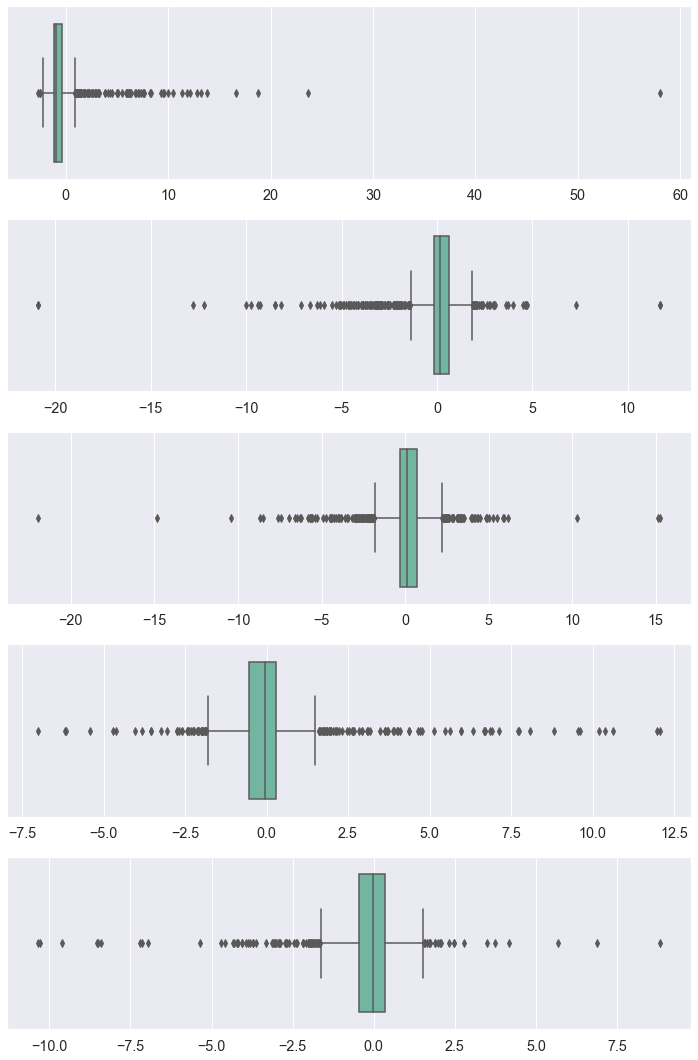

In [25]:
plt.figure(figsize=(10, 15))
for i, arr in enumerate(transform_X[:1000].T):
    plt.subplot(5, 1, i+1)
    sns.boxplot(x=arr, palette='Set2')
plt.tight_layout()

**Вывод:** в первом получившемся признаке произошел перекос выбросов в правую сторону, причем есть очевидный выброс, который даже после нормализации оказался более, чем в 2 раза, больше остальных значений. В остальных признаках выбросы расположены примерно симметрично, при этом, конечно, есть какие-то выбивающиеся аномалии, но они отличаются от остальных элементов не на порядок.

**2.PCA.** Так как мы уже выделили 5 компонент с помощью PCA, по которым будем определять выбросы, то просто визуализируем эти компоненты. Конечно, у PCA есть проблемы, как у Boxplot: нет явного предикта, из-за чего мы можем находить выбросы только "ручками", ну и, очевидно, не все. Также мы, конечно, можем увидеть выбросы по 2 координатам, а не по одной, как у Boxplot, при желании можем увидеть даже по 3, однако и этого может быть недостаточно, чтобы определить выброс, так как он, например, может быть линейной комбинацией 4 или более компонент. Однако PCA, во-первых, полезен, чтоб определить компоненты, по которым будем детектировать выбросы (что мы и сделали), а во-вторых, он довольно удобен в использовании.

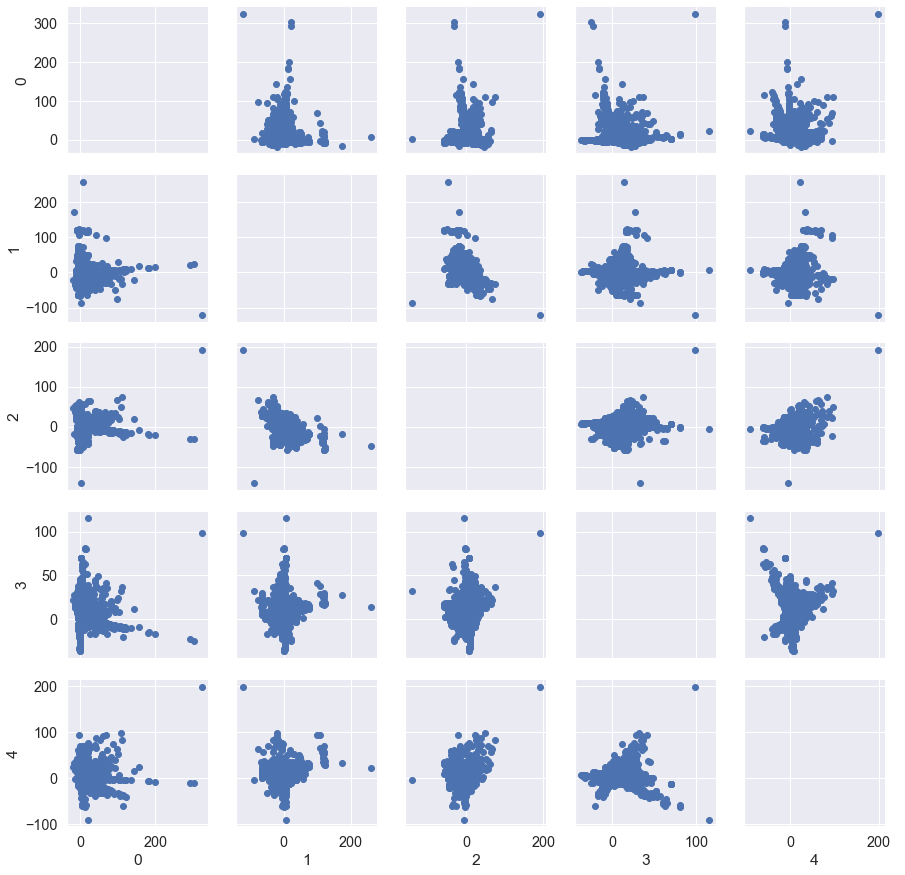

In [26]:
plot = sns.PairGrid(pd.DataFrame(transform_X), palette='RdBu')
plot = plot.map_offdiag(plt.scatter);
plot = plot.add_legend()

**Вывод:** по всем парам координат есть очевиднейшие выбросы. Меньше всего аномалий, как мне кажется, по 2 и 4 координате. Если говорить о выбросах, которые можно определить по 2 координатам, но нельзя определить по одной, то можно привести пример аномалию по 0 и 3 координате чуть правее основного облака. Казалось, нет сильного выброса по оси x, по оси y вообще нормальное значение, однако в целом эта аномалия выбивается из общего числа.

**3.Elliptic envelope.** Метод позволяет легко визуализировать его работу (если рассматривать проекцию на 2 или на 3 коодринаты). Также метод позволяет легко подобрать гиперпараметры (достаточно лишь указать количество желаемых выбросов). Однако метод не умеет определять выбросы, когда у нас несколько довольно далеких друг от друга кластеров (например, можем принять за выброс некоторый кластер, который просто меньше самого большого).

Напишем функцию, которая будет визуализировать pairgrid и возвращать предсказание метода.

In [27]:
def predict_and_visualize_pairgrid(model, args={'contamination': 0.001}, data=pd.DataFrame(transform_X)):
    model = model(**args)
    predict = model.fit_predict(data)
    data['not outlier'] = predict >= 0
    plot = sns.PairGrid(data, hue='not outlier', palette='RdBu')
    plot = plot.map_offdiag(plt.scatter);
    plot = plot.add_legend()
    data.drop('not outlier', axis=1, inplace=True)
    return np.array(predict < 0, dtype=int)

Wall time: 1min 19s


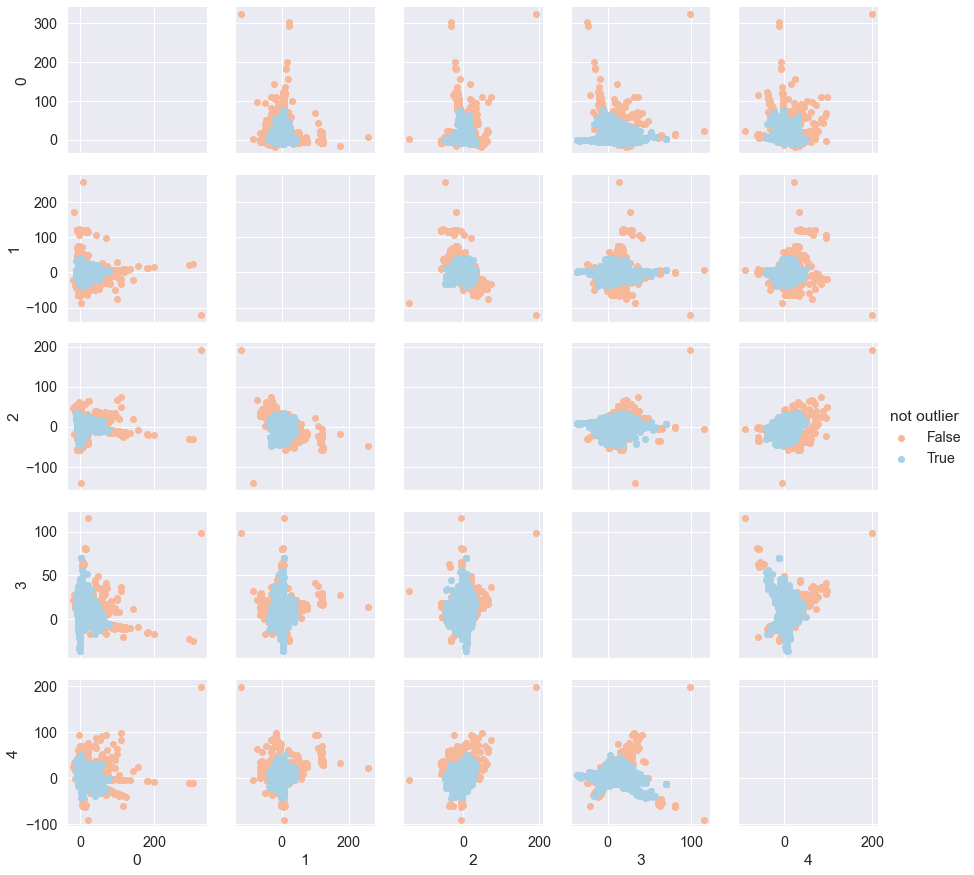

In [28]:
%%time
predict_ellips = predict_and_visualize_pairgrid(EllipticEnvelope)

Проверим, что метод детектирует именно столько выбросов, сколько мы ему указали.

In [29]:
len(predict_ellips[predict_ellips == 1]) / len(predict_ellips)

0.0010006811654248856

Wall time: 1min 13s


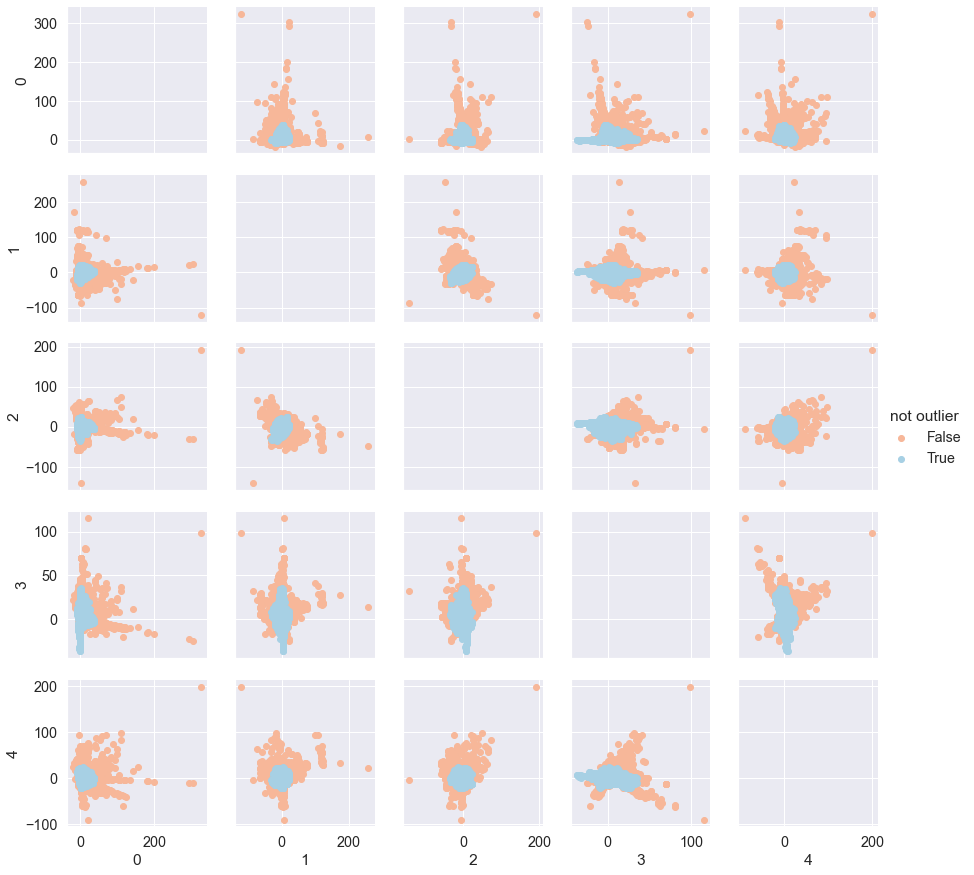

In [31]:
%%time
predict_ellips = predict_and_visualize_pairgrid(EllipticEnvelope, args={'contamination': 0.005})

Подготовим данные для дальнейшей визуализации: выберем первые 1000 точек и 2 координаты из 5.

In [33]:
vis_X = np.concatenate(([transform_X[:, 1]], [transform_X[:, 4]])).T
vis_X = vis_X[:1000]
vis_X

array([[ 0.12493846, -0.23631936],
       [-0.49253622, -1.22337267],
       [ 0.46605516,  1.08326618],
       ...,
       [ 0.29338883,  0.70379964],
       [ 0.81182794, -1.45785257],
       [ 1.48448364, -0.10772174]])

Чтобы визуализировать работу метода, обучим модель на подготовленных признаках.

In [34]:
%%time
model = EllipticEnvelope(contamination=0.005)
model.fit(vis_X)
vis_pred = model.predict(vis_X)

Wall time: 379 ms


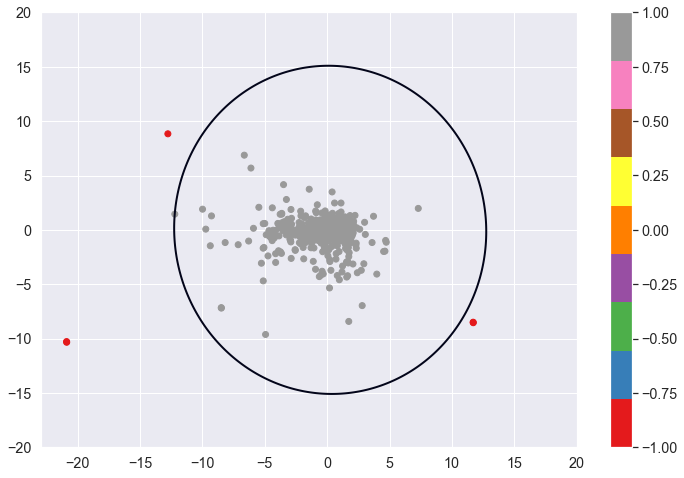

In [35]:
# двумерная сетка
X_grid, Y_grid = np.meshgrid(np.linspace(-20, 20, 500), np.linspace(-20, 20, 500))
Z = model.decision_function(np.c_[X_grid.ravel(), Y_grid.ravel()])
Z = Z.reshape(X_grid.shape)

plt.figure(figsize=(12, 8))
plt.contour(X_grid, Y_grid, Z, levels=[0], linewidths=2)
plt.scatter(vis_X[:, 0], vis_X[:, 1], c=vis_pred, cmap='Set1')
plt.colorbar()

**Вывод:** на самом деле, на 2D графиках оказалось не очень понятна логика детектирования выбросов модели, так как 2D график не может отразить истинную зависимость. Однако можно заметить, что метод выделяет области с наибольшей концентрации в качестве не выбросов, а остальное определяет, как выбросы. При визуализации работы метода мы явно видим замеченную выше тенденцию. Заметим, что визуализация работы метода определила 3 выброса.

**4.IsolationForest.** Метод определяет выбросы по средней высоте данной вершины в дереве с делением по случайному признаку со случайным трешхолдом. Метод довольно легко определяет выбросы по одной из координат, однако, как мне кажется, чем больше типичных координат у выброса, тем сложнее задетектить этот выброс с помощью рассматриваемогои метода. Однако, в отличие от предыдущего метода, IForest умеет определять как область не выбросов не только, как эллиптическую оболочку, но и как область довольно произвольной формы, что позволяет работать лучше с кластерами.

Wall time: 2min 15s


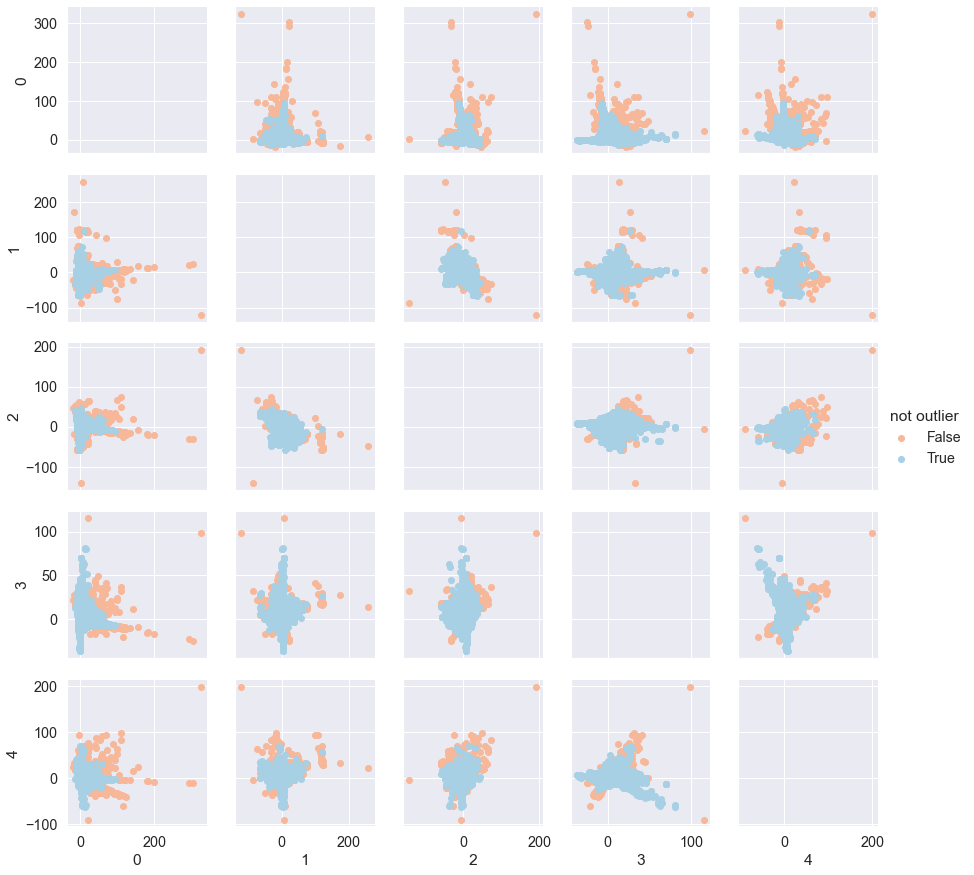

In [36]:
%%time
predict_forest = predict_and_visualize_pairgrid(IsolationForest, args={'contamination': 0.001, 'n_estimators': 1000}, 
                   data=pd.DataFrame(transform_X))

Посмотрим, какую часть от общего количество данных метод определяет, как выброс.

In [37]:
len(predict_forest[predict_forest == 1]) / len(predict_forest)

0.0010006811654248856

Wall time: 2min 16s


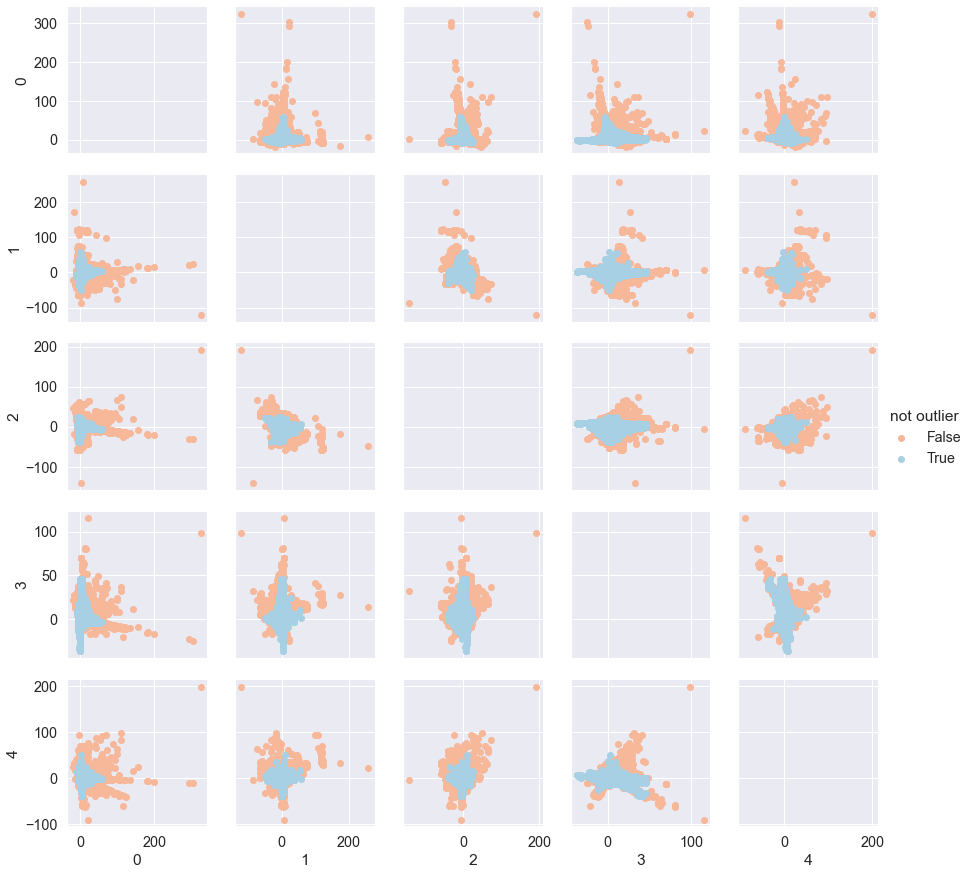

In [39]:
%%time
predict_forest = predict_and_visualize_pairgrid(IsolationForest, args={'contamination': 0.005, 'n_estimators': 1000}, 
                   data=pd.DataFrame(transform_X))

In [41]:
%%time
args={'contamination': 0.005, 'n_estimators': 1000}
isoforest = IsolationForest(**args)
isoforest.fit(vis_X)
vis_pred = isoforest.predict(vis_X)

Wall time: 1.94 s


Wall time: 1.83 s


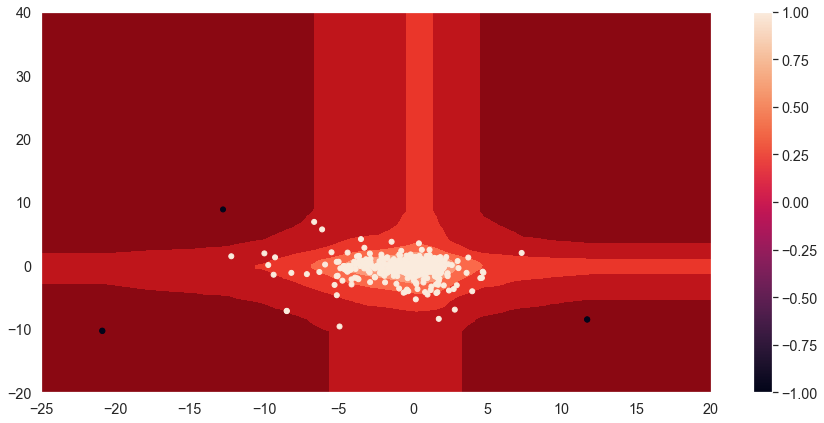

In [42]:
%%time
xx, yy = np.meshgrid(np.linspace(-25, 20, 101), np.linspace(-20, 40, 151))
Z = isoforest.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15, 7))
plt.contourf(xx, yy, Z, cmap=plt.cm.Reds_r)
plt.scatter(vis_X[:, 0], vis_X[:, 1], s=25, c=vis_pred);
plt.colorbar()

**Вывод:** как и в предыдущем методе, на 2D графике мы не очень видим логику работы метода, однако можно заметить, что рассматриваемый метод выделяет более причудливые формы, чем EllipticEnvelope, что довольно логично и что я предполагал до реализации метода. При этом визуализация работы метода лишь подчеркивает выделенные особенности. Заметим также, что этот метод выделил те же 3 выброса, что и предыдущий.

**5.LocalOutlierFactor.** Метод строит локальную плотность точки, за счет, которой, как мне кажется, позволяет определять кластерную структуру и выделять выбросы. Однако надо быть аккуратным с настройкой гиперпараметра количества соседей, так как иначе мы можем маленький кластер определить, как выброс, или, наоборот, не определить как выброс аномалии, случайно оказавшиеся рядом.

Wall time: 33.1 s


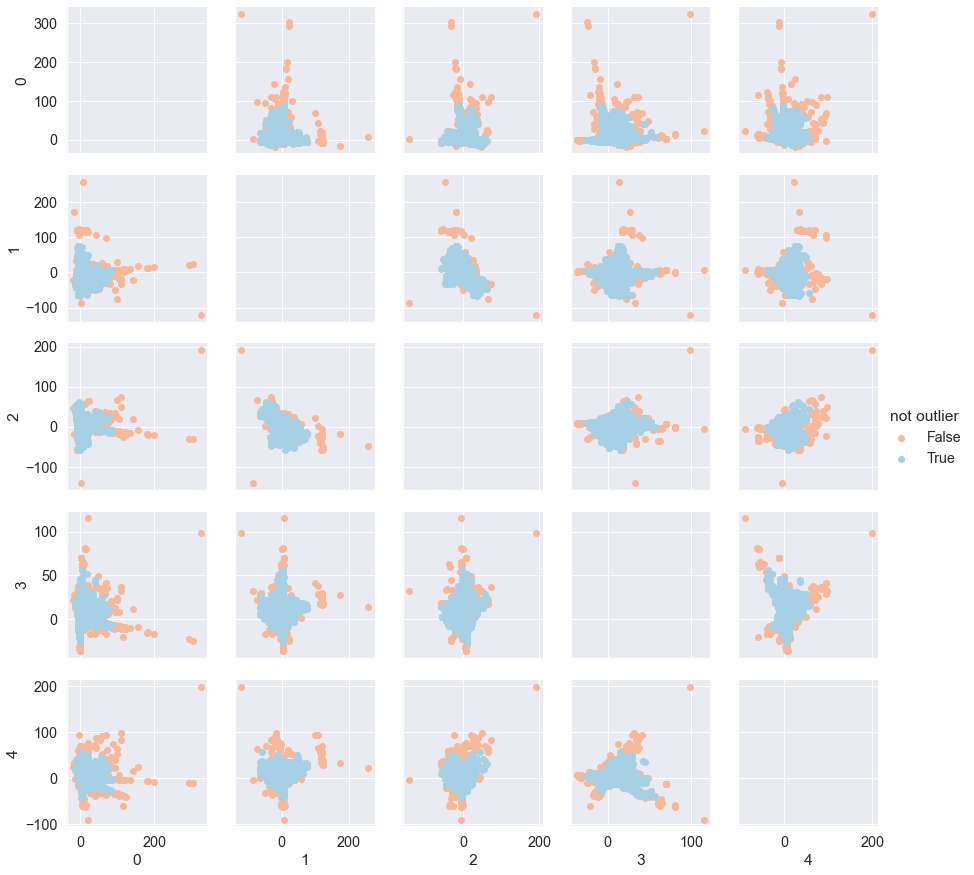

In [43]:
%%time
predict_local = predict_and_visualize_pairgrid(LocalOutlierFactor, args={'contamination': 0.005, 'n_neighbors': 100, 
                                        'n_jobs': -2}, data=pd.DataFrame(transform_X))

Проверим, действительно ли метод определяет столько выбросов, сколько мы ему сказали определить.

In [44]:
len(predict_local[predict_local == 1]) / len(predict_local)

0.005003405827124429

Wall time: 24 s


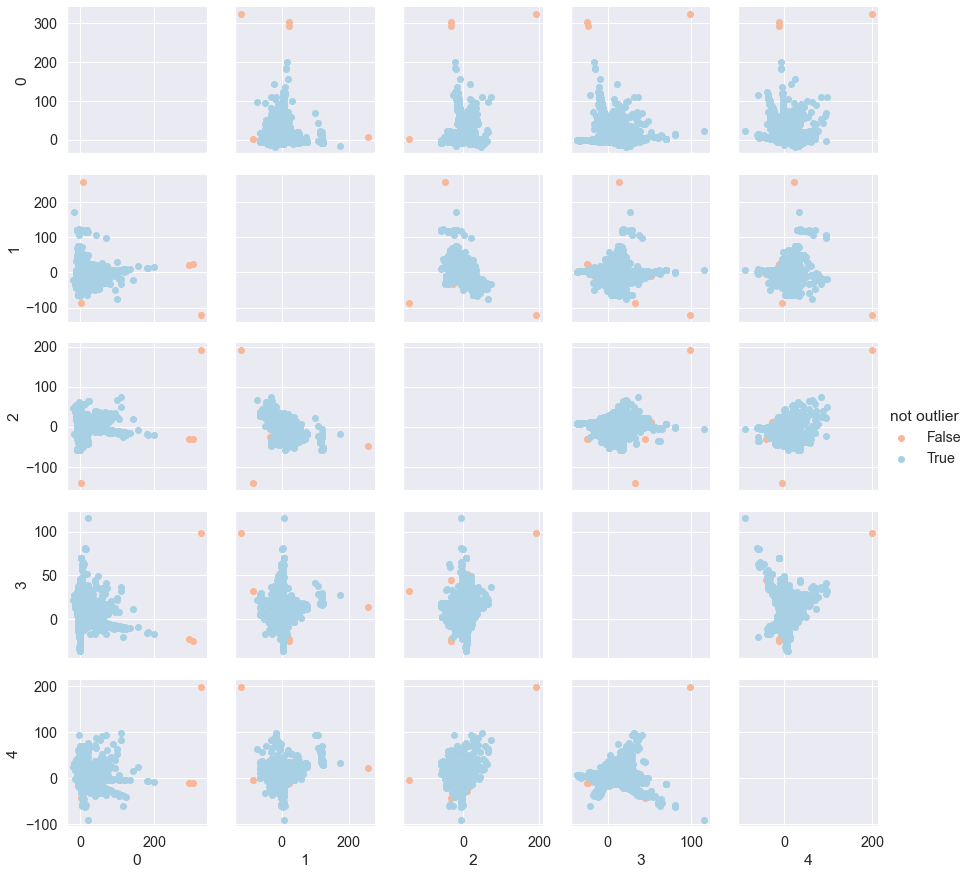

In [46]:
%%time
predict_local = predict_and_visualize_pairgrid(LocalOutlierFactor, args={'contamination': 0.005, 'n_neighbors': 10, 
                                        'n_jobs': -2}, data=pd.DataFrame(transform_X))

Wall time: 26.1 s


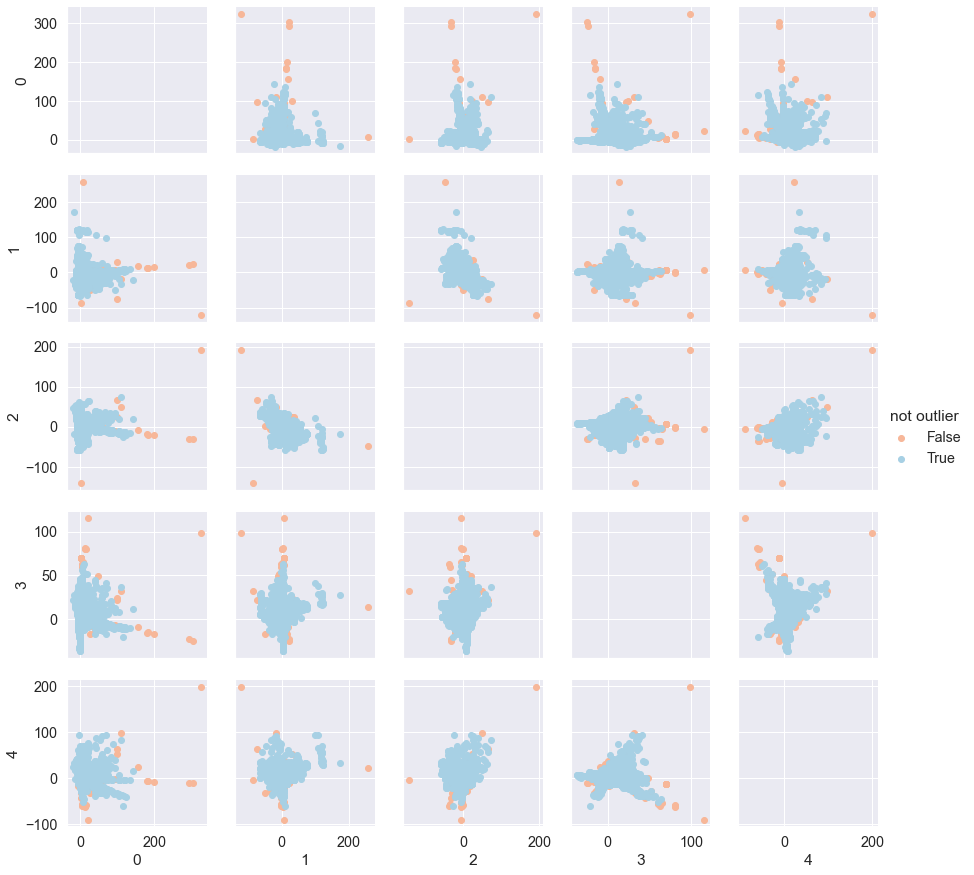

In [48]:
%%time
predict_local = predict_and_visualize_pairgrid(LocalOutlierFactor, args={'contamination': 0.005, 'n_neighbors': 30, 
                                        'n_jobs': -2}, data=pd.DataFrame(transform_X))

Wall time: 28.2 s


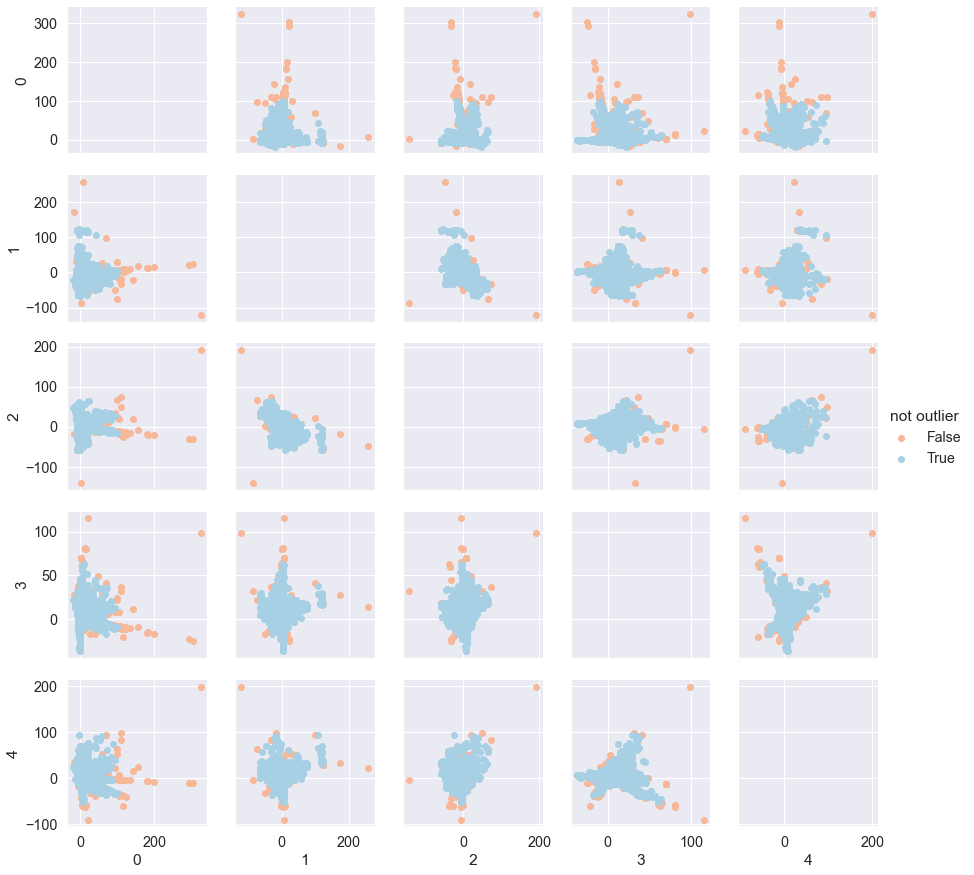

In [50]:
%%time
predict_local = predict_and_visualize_pairgrid(LocalOutlierFactor, args={'contamination': 0.005, 'n_neighbors': 50, 
                                        'n_jobs': -2}, data=pd.DataFrame(transform_X))

In [52]:
lof = LocalOutlierFactor(contamination=0.005, n_neighbors=50)
vis_pred = lof.fit_predict(vis_X)

In [53]:
X_scores = lof.negative_outlier_factor_
X_scores[:5]

array([-0.97681392, -1.21398697, -1.39219087, -1.39394217, -1.03619968])

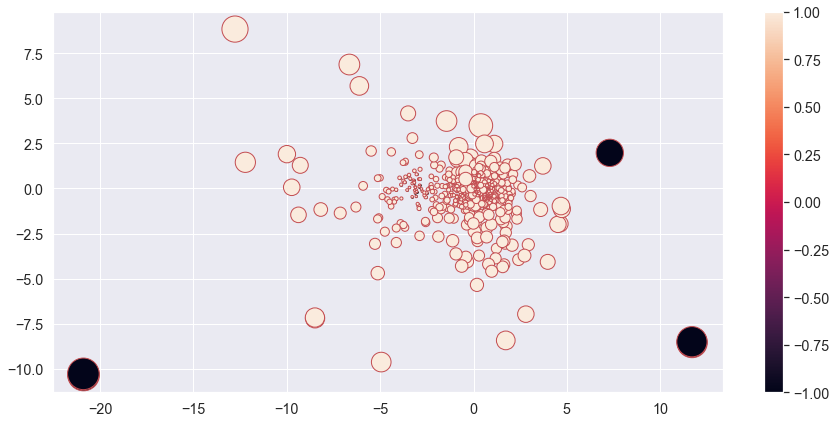

In [54]:
plt.figure(figsize=(15, 7))
plt.scatter(vis_X[:, 0], vis_X[:, 1], color='k', s=3)
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(vis_X[:, 0], vis_X[:, 1], s=1000 * radius, edgecolors='r', c=vis_pred, lw=1);
plt.colorbar()

**Вывод:** если честно, то в данном методе я не очень понял его pairplot. На них кажется, что чем меньше гиперпараметр соседей, тем меньше метод детектирует выбросов, однако это не так. Я могу предположить, что при малом параметре соседей метод считает за выбросы немного отстоящие от основной массы элементы, которые просто перекрываются многочисленными элементами, которые метод не счел за выбросы. Мне кажется, что оптимальный параметр соседей &mdash; около 50, так как с одной стороны метод с этим гиперпараметром замечает довольно много выбросов, которые человечекий взгляд бы тоже отнес к таковым, а с другой, не относит к выбросам те элементы, которые мы бы тоже не отнесли. Касаемо визуализации работы метода: заметим, что метод определил немного не те же выбросы, что и предыдущие (различается одна точка). При этом видно, почему метод отнес ту или иную точку к выбросу.

**6.DBSCAN.** Мне кажется, наилучший метод для детектирования выбросов, так как он видит четкую кластерную структуру и способен довольно легко определить, является ли элемент выбросом. Однако у него есть пара существенных минусов. Первый: сложный подбор гиперпараметров, которые сложно подобрать интуитивно. Второй: метод требует много вычислительных ресурсов и памяти и падает на больших данных, как это произошло в дальнейшем у меня. Поэтому я разбил данные на несколько частей, проанализировал каждую из них по отдельности, а потом собрал результаты вместе. Понятно, что таким образом мы не уловим зависимости между элементами, находящимися в разных частях, но, как мне кажется, таким образом мы будем плохо работать лишь с небольшими кластерами.

In [55]:
def visualizate_and_pred_dbscan(data=transform_X, args={'eps': 3, 'min_samples': 2}):
    subsample = 50000
    n_iters = int(len(data) / subsample + 1)
    predict = np.array([])
    for it in tqdm(range(n_iters)):
        if it != n_iters - 1:
            arr = data.iloc[it * subsample: (it + 1) * subsample]
        else:
            arr = data.iloc[it * subsample:]
        model = DBSCAN(**args)
        cur_pred = model.fit_predict(arr)
        predict = np.append([predict], [cur_pred])
    data['not outlier'] = predict >= 0
    plot = sns.PairGrid(data, hue='not outlier', palette='RdBu')
    plot = plot.map_offdiag(plt.scatter);
    plot = plot.add_legend()
    data.drop('not outlier', axis=1, inplace=True)
    return np.array(predict < 0, dtype=int)

100%|██████████| 6/6 [12:19<00:00, 123.32s/it]


Wall time: 12min 40s


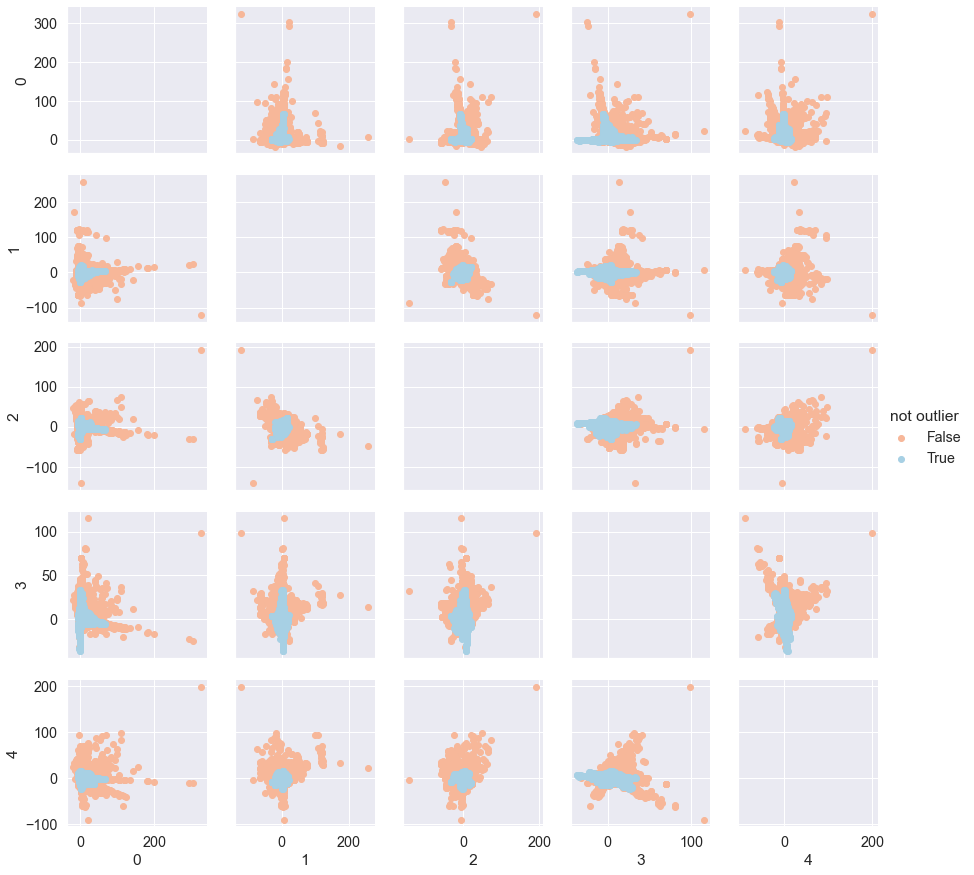

In [56]:
%%time
predict_dbscan = visualizate_and_pred_dbscan(args={'eps': 5, 'min_samples': 10}, 
                                                data=pd.DataFrame(transform_X))

Посмотрим, какую часть данных метод задетектил как выброс.

In [57]:
len(predict_dbscan[predict_dbscan == 1]) / len(predict_dbscan)

0.008644480804477434

Довольно неплохо. На самом деле, все получилось не с первого раза, просто при других гиперпараметрах либо ноут не вывозил, либо получались совсем неадекватные доли выбросов.

In [58]:
db = DBSCAN(eps=5, min_samples=10)
preds = db.fit_predict(vis_X)

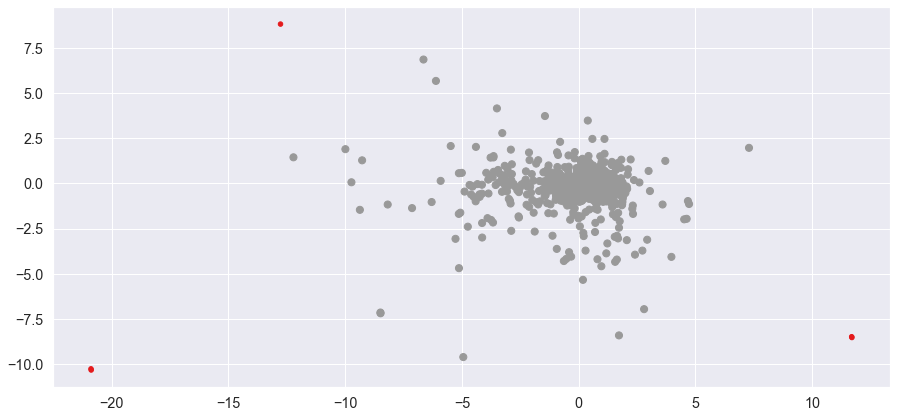

In [59]:
plt.figure(figsize=(15, 7))
plt.scatter(vis_X[:, 0], vis_X[:, 1], s=20 + 30 * (preds!=-1), c=preds, cmap='Set1');

**Вывод:** на pairgrid метод увидел какие-то не совсем очевидные человеческому глазу кластерные структуры. При визуализации же метож определяет ровно те элементы в качестве выбросов, что и первые 2 метода. Интуитивно кажется, что метод должен быть неплох, так как он хорошо должен справляться и с определением кластеров, и с определением выбросов. Проверим это предпожение по метрикам в следующем пункте.

Для оценки качества каждого метода посчитайте значения нескольких метрик качества классификации и запишите значения в таблицу. Поясните, почему вы выбрали эти метрики. 

Ввиду того, что нам лучше ошибиться предсказав, что транзакция мошенническая, чем наоборот, будем отдавать предпочтение recall, а не precision. Напишем функцию, которая будет записывать в таблицу значения.

In [60]:
compare_table = None


def add_results_in_comparison_table(method: str, y_true, y_forecast) -> pd.DataFrame:
    """
    Добавляет новую строчку в таблицу compare_table с результатами текущей модели.
    Если ранее модель была уже добавлена в таблицу, то старая строчка перезапишется на новую.
    
    Параметры:
    - method: имя модели.
    - y_true: истинные значения.
    - y_forecast: предсказанные значения.
    """
    
    # Обращаемся к глобальной переменной
    global compare_table
    
    # Считаем метрики
    result_row = {
        'method': method,
        "recall": recall_score(y_true=y_true, y_pred=y_forecast),
        "f20-score": fbeta_score(y_true=y_true, y_pred=y_forecast, beta=20),
        "f5-score": fbeta_score(y_true=y_true, y_pred=y_forecast, beta=5),
        "f1-score": fbeta_score(y_true=y_true, y_pred=y_forecast, beta=1)
    }
    
    # Записываем результат в таблицу
    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table['method']):
            compare_table = compare_table[compare_table['method'] != method]

        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table

In [61]:
add_results_in_comparison_table('EllipticEnvelope', Y, predict_ellips)
add_results_in_comparison_table('IsolationForest', Y, predict_forest)
add_results_in_comparison_table('LocalOutlierFactor', Y, predict_local)
add_results_in_comparison_table('DBSCAN', Y, predict_dbscan)

,method,recall,f20-score,f5-score,f1-score
0,EllipticEnvelope,0.038618,0.038436,0.035993,0.019823
1,IsolationForest,0.060976,0.060689,0.056831,0.031299
2,LocalOutlierFactor,0.073171,0.072826,0.068197,0.037559
3,DBSCAN,0.140244,0.138857,0.121528,0.046716


Сделайте выводы.

**Вывод:** по таблице можно сказать, что эллиптическая оболочка показала себя хуже всех, дальше по всем метрикам изолирующий лес, потом локальный уровень выброса, а DBSCAN показал себя с отрывом лучше всех. Единственное, стоит отметить, что доля операций, которые мы считаем мошенническими несколько больше, чем у остальных методов. Из этого можно сделать вывод, что DBSCAN немного чаще ложно считает операцию мошеннической, но в противовес этому определяет мошеннические операции довольно неплохо (при этом у нас не та ситуация, когда мы считаем почти все транзакции мошенническими, так как доля операций, которые мы считаем мошенническими не сильно большая).

### Ситуация 2: построение модели распознавания новых мошеннических схем 
Теперь рассмотрим методы детектирования новизны.  

Разделите выборку на две части следующим образом:  
* в первой части данных 50000 легальных транзакций, мошеннических нет, это будет трейн;  
* во второй части данных все остальные данные, это будет тест.

*Внимание.* Нельзя использовать мошеннические операции при обучении или выборе модели. Этих данных нет при построении модели, они появятся потом. Когда они появятся, ваша модель должна быть уже готова их задетектировать.

Нормализуйте данные по трейну. Используйте `RobustScaler` из `sklearn`, поскольку, возможно не все операции, которые отмечены как не мошеннические, действительно легальные.

In [62]:
X_train = data.sort_values(by='Class')[:50000]
Y_train = X_train['Class']
X_train.drop('Class', axis=1, inplace=True)
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Shifted_time
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
189814,-5.809290,0.180870,-2.698260,4.886691,1.496554,1.833805,-1.417844,-6.071499,-3.150815,1.143182,...,2.303073,-0.183163,0.049842,-0.220697,1.390550,1.035940,1.110960,-1.758895,0.76,0.0
189815,2.136948,0.024433,-2.440339,-0.280203,0.951061,-0.799101,0.607870,-0.314005,0.054811,0.201116,...,0.152297,0.488799,-0.077620,0.236435,0.479284,0.221746,-0.099236,-0.088561,3.70,0.0
189816,-1.156768,0.135422,3.113868,4.420894,0.757698,1.234795,-1.234156,0.721934,-1.676275,1.465244,...,0.390024,0.767668,-0.064709,0.746197,-0.080808,0.475584,0.105618,0.128784,9.81,0.0
189817,1.767787,-0.301029,-2.215079,0.511939,0.423751,-0.984541,0.509947,-0.398095,0.540116,-0.615062,...,0.258679,0.570469,-0.257998,-0.764858,0.285443,-0.074687,-0.027915,-0.005763,174.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149334,1.799264,0.458242,-0.544305,4.286983,0.518047,0.171616,0.290163,-0.294345,0.562998,0.852556,...,-0.042154,0.383766,-0.074580,-0.099324,0.342940,0.146099,-0.054043,-0.049997,69.22,0.0
149335,-0.826099,0.756107,-0.339445,-0.314693,-0.294226,0.425215,2.301057,-0.412917,1.358141,-1.752614,...,-0.211321,-0.031535,0.268289,0.328531,-0.188694,-0.496470,0.446698,0.168376,362.46,0.0
149336,0.003097,0.551709,1.374499,-0.954777,0.540655,0.020932,0.473265,-0.221213,2.004189,-1.173104,...,-0.438012,-0.781667,-0.201302,-1.097818,-0.150994,-0.276140,-0.162938,-0.222145,0.77,5.0
149337,2.041722,0.067193,-1.291561,0.350165,0.353528,-0.593418,0.017448,-0.255477,1.582261,-0.198770,...,0.144744,0.764748,0.037247,0.743657,0.234644,-0.203640,-0.054054,-0.067443,1.79,0.0


In [63]:
X_test = data.sort_values(by='Class')[50000:]
Y_test = X_test['Class']
X_test.drop('Class', axis=1, inplace=True)
X_test

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Shifted_time
149339,-2.169094,-0.324509,1.284432,4.987514,1.591528,0.456044,1.617674,-1.524913,1.373529,3.473512,...,-0.696347,0.896404,0.755369,-0.128048,-0.440419,0.252077,-1.570085,-0.861307,48.59,1.0
149340,-0.626271,0.722456,-0.291464,-1.221416,1.409096,-1.126358,1.327906,-0.586138,0.599602,-0.815064,...,0.067524,0.679652,-0.260069,-0.237152,0.137854,1.050186,-0.217313,0.111560,10.50,1.0
149341,-1.137545,1.061560,-1.179565,-2.208254,1.242497,-1.536758,1.198501,-0.182393,0.988549,-1.074034,...,0.123842,0.769796,-0.004455,-0.266662,-0.285137,0.663062,-0.185644,0.170936,1.00,2.0
149342,-0.389500,0.870332,0.478407,-1.079181,1.247000,-0.209736,1.106986,-0.159277,1.040142,-1.319435,...,-0.411965,-1.037795,-0.092089,-0.049240,-0.141051,0.063758,0.000267,0.122888,24.99,2.0
149343,1.870450,0.133883,-1.554957,1.639545,0.532998,-1.009226,0.727964,-0.571060,1.340380,-0.179962,...,-0.042128,0.205753,-0.086101,-0.109325,0.444135,-0.536038,-0.051718,-0.052105,95.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184379,-1.141559,1.927650,-3.905356,-0.073943,-0.044858,-1.756999,-1.217416,0.364563,-2.770148,-3.216188,...,0.102081,-0.531496,-0.328741,0.393100,0.568435,0.786605,-0.146102,0.076211,25.00,1.0
42741,-9.001351,6.613284,-12.423635,7.519929,-10.266255,-2.113208,-9.984287,5.541941,-7.383705,-13.215172,...,1.775891,-1.224758,0.082594,0.452089,0.463827,-0.296928,0.526506,-0.450890,459.07,0.0
107067,-1.512516,1.133139,-1.601052,2.813401,-2.664503,-0.310371,-1.520895,0.852996,-1.496495,-4.056293,...,0.729828,0.485286,0.567005,0.323586,0.040871,0.825814,0.414482,0.267265,318.11,2.0
191690,1.183931,3.057250,-6.161997,5.543972,1.617041,-1.848006,-1.005508,0.339937,-2.959806,-3.851722,...,0.109185,-0.931072,-0.064175,-0.007013,0.345419,0.064558,0.476629,0.323740,0.00,0.0


In [64]:
rs_train = RobustScaler()
train_transform = rs_train.fit_transform(X_train)
test_transform = rs_train.transform(X_test)
test_transform

array([[-0.81925467, -0.24307124,  1.03653011, ..., -5.78143039,
         0.37703756,  1.        ],
       [-0.26289261,  0.48748339,  0.16139656, ...,  0.97745331,
        -0.16286322,  1.        ],
       [-0.44726465,  0.72410504, -0.33178725, ...,  1.3899577 ,
        -0.29751949,  2.        ],
       ...,
       [-0.582484  ,  0.77405135, -0.56584957, ...,  2.05919442,
         4.19730687,  2.        ],
       [ 0.38989012,  2.11666536, -3.09865283, ...,  2.45154865,
        -0.31169383,  0.        ],
       [-0.41497544,  0.8906372 ,  0.22307288, ...,  0.68790133,
         0.24748405,  0.        ]])

Обучите на трейне `OneClassSVM`.

*Замечание.* На занятии мы поговорили только про его реализацию. Этого достаточно для выполнения задания.

In [65]:
%%time
SVM = OneClassSVM()
SVM.fit(train_transform)

Wall time: 3min 12s


OneClassSVM()

Получите результат на тесте и посчитайте метрики качества классификации модели.

In [66]:
%%time
prediction = SVM.predict(test_transform)
prediction = np.array(prediction < 0, dtype=int)

Wall time: 9min 27s


In [67]:
fbeta_score(Y_test, prediction, beta=5)

0.1091384688800714

In [68]:
fbeta_score(Y_test, prediction, beta=1)

0.009373365827668203

In [69]:
len(prediction[prediction == 1]) / len(prediction)

0.4295418345357444

**Вывод:** OneClassSVM по f5-score справился довольно неплохо относительно других методов, а вот по f1-score &mdash; не очень (даже хуже EllipticEnvelope). Это произошло потому, что OneClassSVM слишком часто доставлял неудобство пользователям, в 42% случая заставляя их подтвердить свою операцию, хотя, мошеннических операций на 2 порядка меньше. Скорее всего, он увидел какие-то данные, которых не было на тесте, и счел их за новизну, хотя на самом деле они не являются выбросом.